In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2024 -  United Kingdom Research and Innovation
#  Copyright 2024 -  The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by: Jakob S. Jørgensen (DTU)
#                Evangelos Papoutsellis(Finden)
#                Gemma Fardell (UKRI-STFC)
#                Edoardo Pasca (UKRI-STFC)     
#                Laura Murgatroyd (UKRI-STFC)
#                Margaret Duff (UKRI-STFC)
#                   

# Helsinki Tomography Challenge - Limited Angle CT Reconstruction 


NOTE: this notebook takes a little while to run so we suggest that you "run all cells" before starting to read! 


The purpose of the challenge is to recover the shapes of 2D targets imaged with limited-angle tomography on a lab based cone beam set-up. 

The training set of the HTC2022 challenge consist of homogenous acrylic disk phantoms of 70 mm in diameter, with holes of varying shapes made with a laser cutter. Each disk has a different number of irregular holes in random locations:

![image](./htc_code/htc_discs.jpg)

The required outcome of the challenge was an algorithm which takes in the X-ray data, i.e., the sinogram and it’s associated metadata about the measurement geometry, and produces a reconstruction which has been segmented into two components: air and plastic. For more details of the challenge see https://fips.fi/data-challenges/helsinki-tomography-challenge-2022/ .


The CIL developer team submitted 5 algorithm submissions to the challenge with algorithm 2 gaining 3rd place, the highest non-machine learning based solution. The paper describing the solution can be found https://doi.org/10.3934/ammc.2023011 and a blog https://ccpi.ac.uk/the-helsinki-tomography-challenge-2022-part-1/ 

This notebook takes you through the development and prototyping process used by the team during preparation of the challenge submission. We demonstrate the results on one 50 degree limited angle test data set. 

In this notebook we do not discuss the segmentation, instead use a segmentation algorithm based on Otsu thresholding (for more information see "htc_code/helper_functions.py")

The objective of this notebook is to see  examples of:
- incorporating prior knowledge of a problem in an variational regularisation framework 
- utilising the flexibility and near-math syntax of the CIL optimisation toolkit to prototype different reconstruction objectives 
- the CIL Block Framework and PDHG optimisation algorithm



## Imports

In [2]:

import numpy as np
from htc_code.helper_functions import *
import matplotlib.pyplot as plt
from skimage.transform import rotate  
from cil.utilities.display import show2D, show_geometry
from cil.recon import FDK
from cil.optimisation.algorithms import FISTA, PDHG
from cil.optimisation.functions import LeastSquares, TotalVariation, L1Norm, MixedL21Norm, L2NormSquared, IndicatorBox, BlockFunction, ZeroFunction
from cil.optimisation.operators import GradientOperator, IdentityOperator, BlockOperator, FiniteDifferenceOperator
from cil.plugins.tigre import ProjectionOperator

: 

## Load the data 

We use one of the training data examples available on [zenodo](https://zenodo.org/records/6984868) which can be downloaded from: https://zenodo.org/records/6984868/files/htc2022_ta_full.mat. If you are running this notebook locally you will need to download the data and change the path in the following cell. 

First consider the full dataset: 

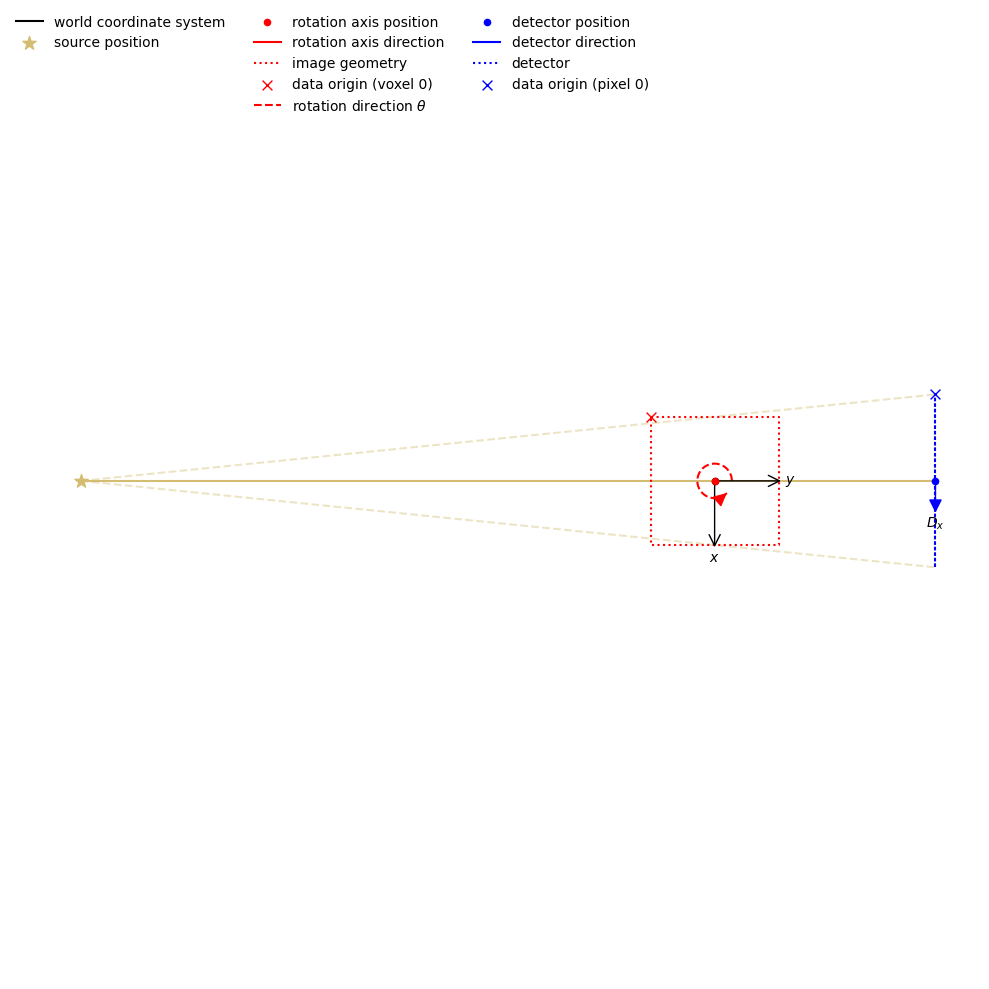

In [ ]:
# Load the full data:
full_data = load_htc2022data("/mnt/share/materials/SIRF/Fully3D/CIL/HTC/htc2022_ta_full.mat")
show_geometry(full_data.geometry)
ig=full_data.geometry.get_ImageGeometry()
fdk =  FDK(full_data, ig)
recon_full = fdk.run()
show2D([recon_full, apply_crazy_threshold(recon_full)], title=[' Full angle FDK reconstruction', 'Thresholded full angle FDK reconstruction']);

We can now subset the data considering restricted angles. We restrict to 50 angles but you can always change this and rerun the notebook if you wish. In the next cell we subset the data, print out the chosen angles and plot these in a circle to demonstrate the chosen wedge of angles. 

[ -0.   -0.5  -1.   -1.5  -2.   -2.5  -3.   -3.5  -4.   -4.5  -5.   -5.5
  -6.   -6.5  -7.   -7.5  -8.   -8.5  -9.   -9.5 -10.  -10.5 -11.  -11.5
 -12.  -12.5 -13.  -13.5 -14.  -14.5 -15.  -15.5 -16.  -16.5 -17.  -17.5
 -18.  -18.5 -19.  -19.5 -20.  -20.5 -21.  -21.5 -22.  -22.5 -23.  -23.5
 -24.  -24.5 -25.  -25.5 -26.  -26.5 -27.  -27.5 -28.  -28.5 -29.  -29.5
 -30.  -30.5 -31.  -31.5 -32.  -32.5 -33.  -33.5 -34.  -34.5 -35.  -35.5
 -36.  -36.5 -37.  -37.5 -38.  -38.5 -39.  -39.5 -40.  -40.5 -41.  -41.5
 -42.  -42.5 -43.  -43.5 -44.  -44.5 -45.  -45.5 -46.  -46.5 -47.  -47.5
 -48.  -48.5 -49.  -49.5 -50. ]


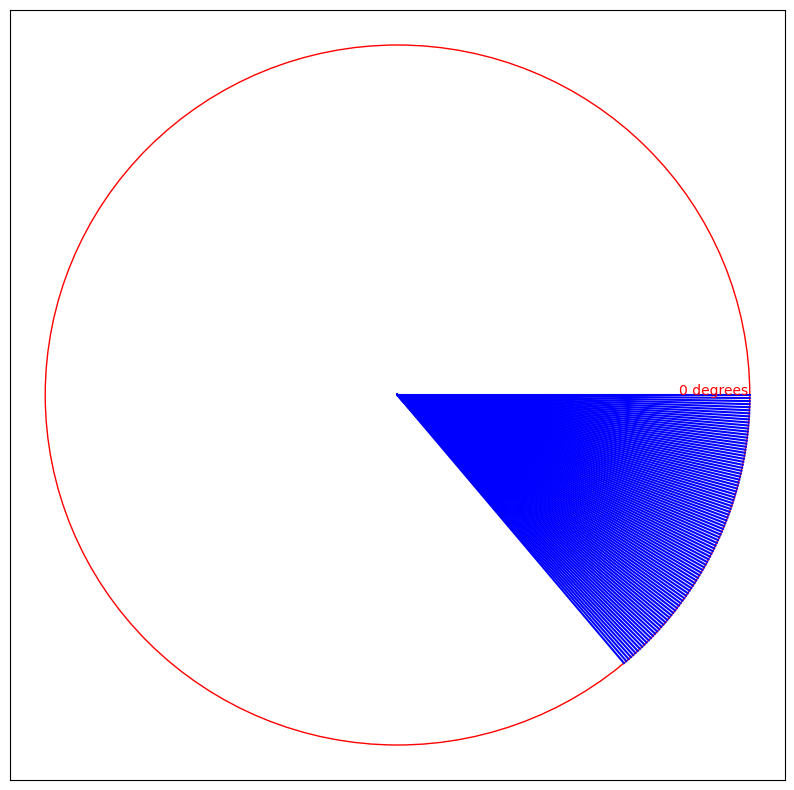

In [4]:
data=generate_reduced_data(full_data, 0, 50)
print(data.geometry.angles)

plt.figure(figsize=(10,10))
for angle in data.geometry.angles:
    plt.plot([0, np.cos(angle*2*np.pi/360)], [0, np.sin(angle*2*np.pi/360)], color='blue')
circle1=plt.Circle((0, 0), 1.0, color='r', fill=False)
plt.gca().add_patch(circle1)
plt.text(0.8,0 , '0 degrees', color='r')
plt.xticks([])
plt.yticks([])
plt.show()



We can visualise the data. From the left hand axis you can see the limited angles again: 

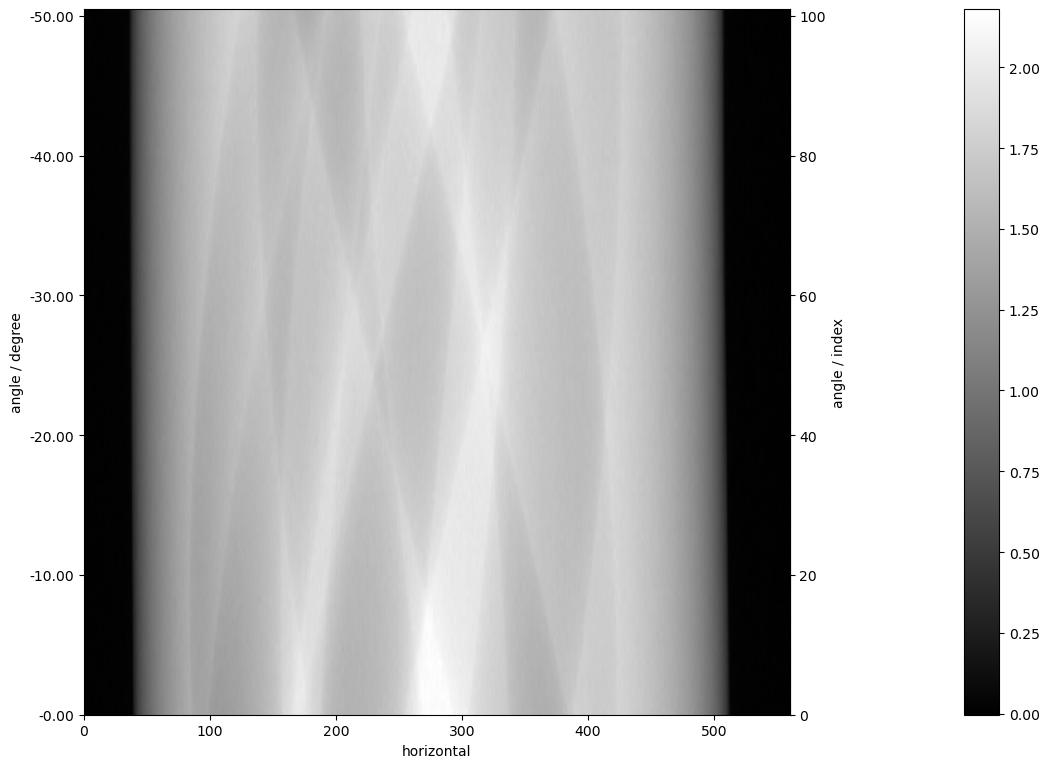

In [5]:

show2D(data)

We can do an FDK reconstruction to see the effect of subsetting the angles

FDK recon

Input Data:
	angle: 101
	horizontal: 560

Reconstruction Volume:
	horizontal_y: 560
	horizontal_x: 560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



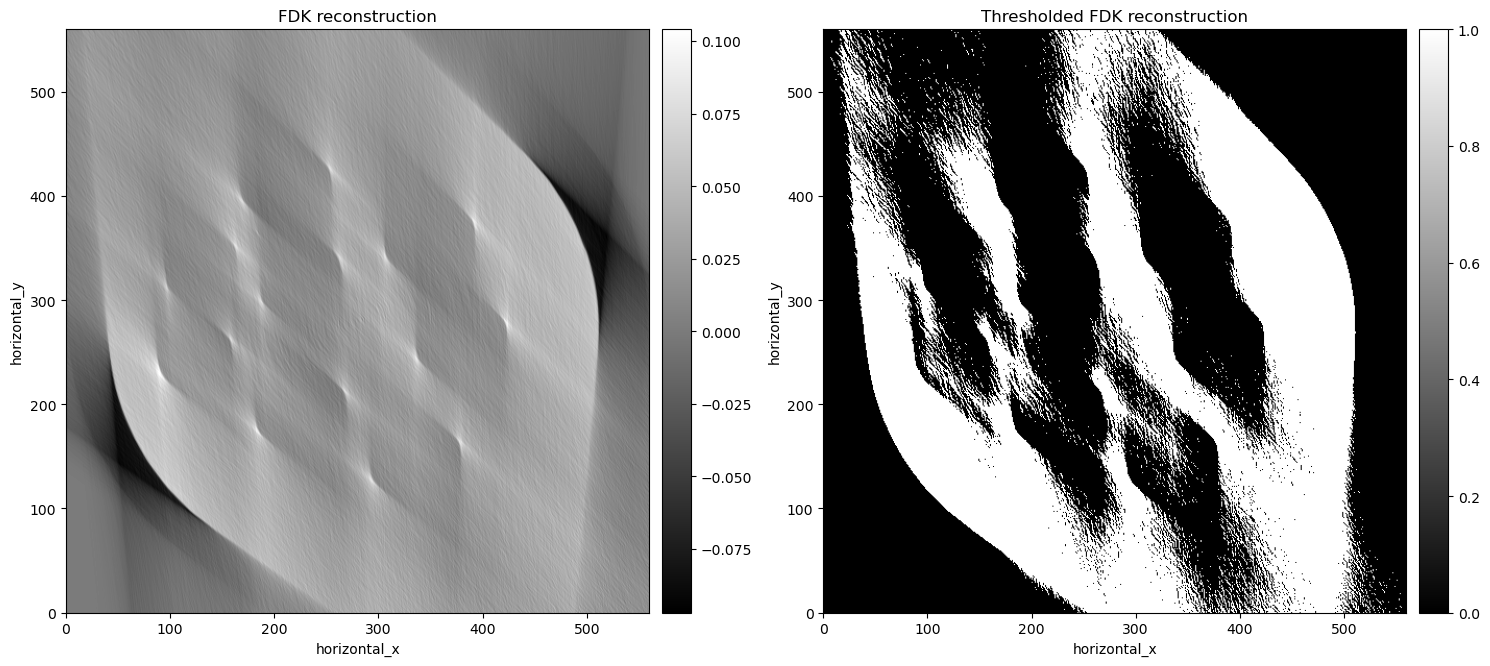

In [6]:

fdk =  FDK(data, ig)
recon = fdk.run()
show2D([recon, apply_crazy_threshold(recon)], title=['FDK reconstruction', 'Thresholded FDK reconstruction']);

We see that the missing angles leads to poor reconstructions along the edges perpedicular to the observed angles. 

## Known information 

We now add additional information to the reconstruction through preproccessing and variational regularisation. We utilise the following facts:
- The objects are made of a single homogeneous material​
- The objects have sharp edges 
- The objects are approximately disk shaped
- There is zero attenuation value outside the object 
- There is a constant attenuation value of 0.0409 mm-1 inside the object
- The limited observation angles are known 


Throughout the next sections we will highlight in bold where we have used these assumptions. 

## Preprocess the data

We first normalise the data and pad with zeros. For more information see the "helper_functions.py" file. 

FDK recon

Input Data:
	angle: 101
	horizontal: 732

Reconstruction Volume:
	horizontal_y: 560
	horizontal_x: 560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



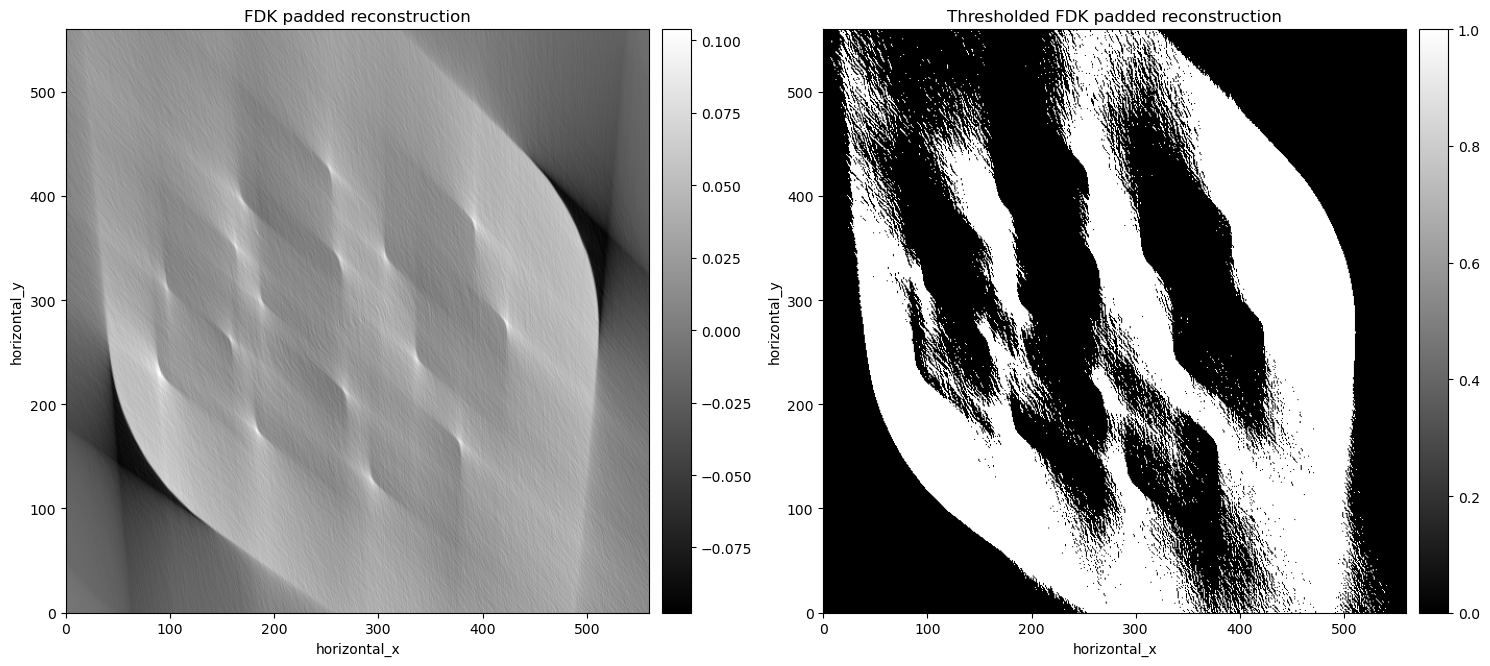

In [7]:
# renormalise data
data_renorm = correct_normalisation(data)
# pad data
data_pad = pad_zeros(data_renorm)



#plot the reconstructed image
fdk =  FDK(data_pad, ig)
recon = fdk.run()
show2D([recon, apply_crazy_threshold(recon)], title=['FDK padded reconstruction', 'Thresholded FDK padded reconstruction']);

When plotting a line plot, along the centre of the reconstructed images we see evidence of beam hardening. Beam hardening is when the energy distribution of X-rays shifts toward the higher side as X-rays go through an object. It is visible in the line plot as a "u" shaped "cup" where the material should have a constant absorption value, such as on the right hand side in this plot. 

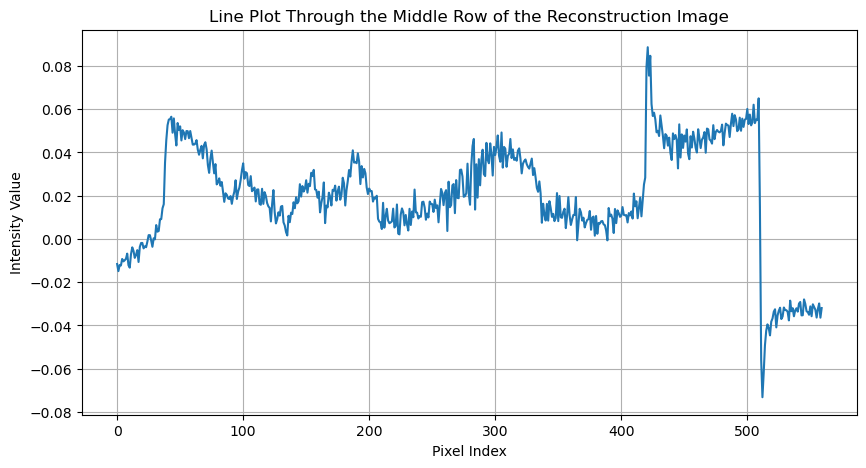

In [8]:
# Extract the middle row of the reconstruction image
middle_row = recon.array[recon.shape[0] // 2, :]

# Plot the values
plt.figure(figsize=(10, 5))
plt.plot(middle_row)
plt.title('Line Plot Through the Middle Row of the Reconstruction Image')
plt.xlabel('Pixel Index')
plt.ylabel('Intensity Value')
plt.grid(True)
plt.show()

Correcting the beam hardening artefacts is relatively straightforward for this example as the object being imaged is made of **one constant material** and the training data for the challenge contained the results of imaging a  solic disk (https://zenodo.org/records/6937616/files/htc2022_solid_disc_full.mat)  . We can use the `correct_beam_hardening` function from the `helper_functions` module to correct the beam hardening artifacts. This gives a small improvement to the reconstructed image and line profile:

FDK recon

Input Data:
	angle: 101
	horizontal: 732

Reconstruction Volume:
	horizontal_y: 560
	horizontal_x: 560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



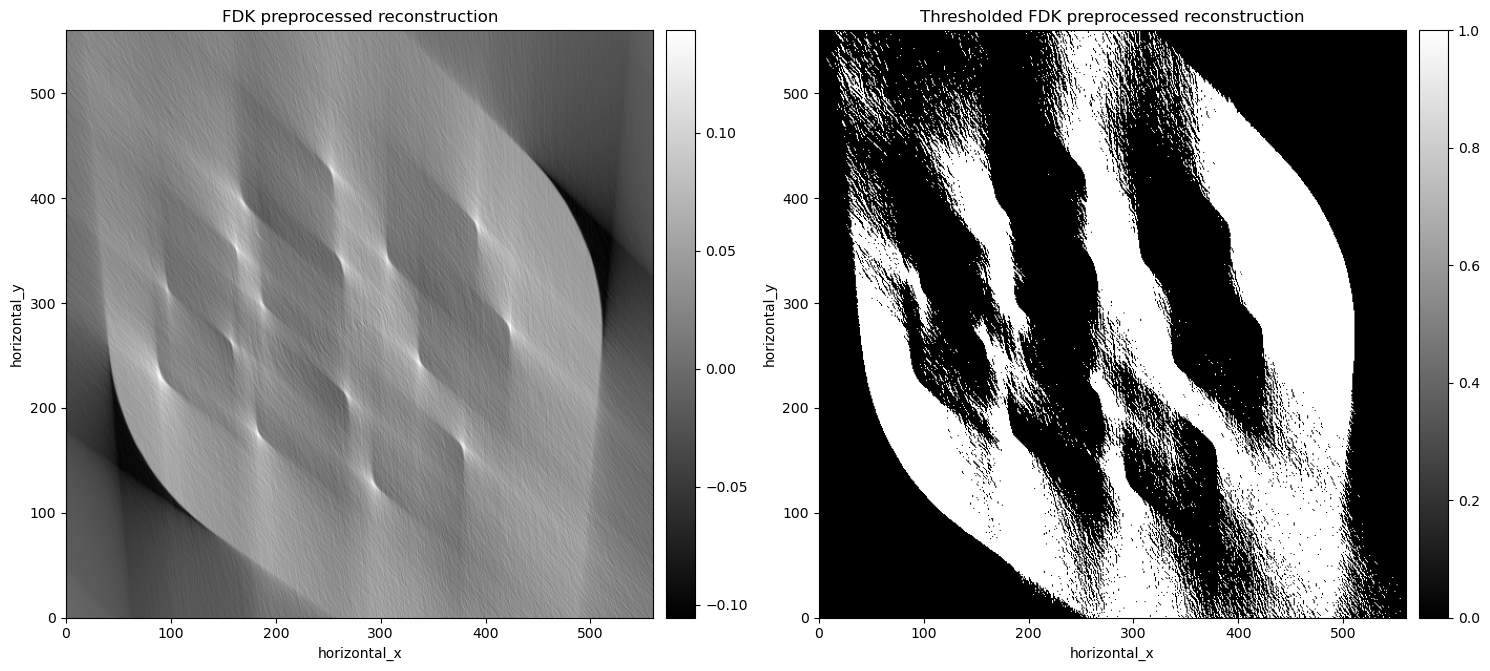

In [9]:
# apply beam hardening correction
data_preprocessed = apply_BHC(data_pad)

#plot the reconstructed image
fdk =  FDK(data_preprocessed, ig)
recon_preprocessed = fdk.run()
show2D([recon_preprocessed, apply_crazy_threshold(recon_preprocessed)], title=['FDK preprocessed reconstruction', 'Thresholded FDK preprocessed reconstruction']);

There is no visible improvement to the reconstruction or segementation but the line plot looks a little better: 

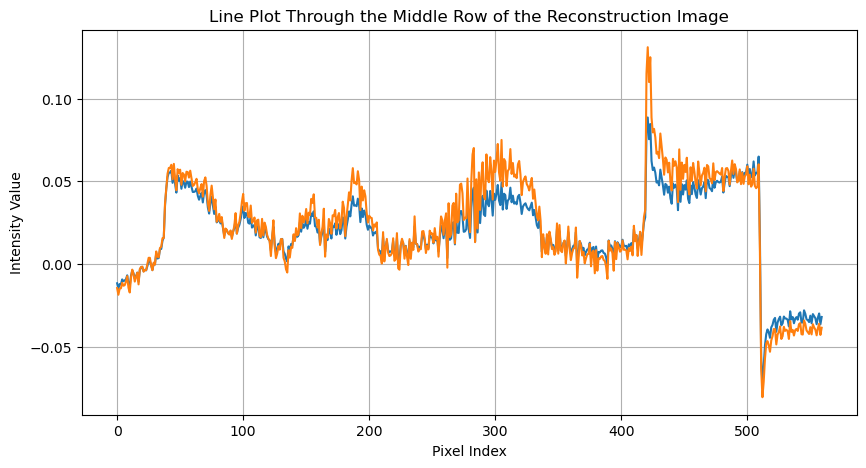

: 

In [10]:
# Extract the middle row of the reconstruction image
middle_row = recon.array[recon.shape[0] // 2, :]
middle_row_preprocessed = recon_preprocessed.array[recon.shape[0] // 2, :]

# Plot the values
plt.figure(figsize=(10, 5))
plt.plot(middle_row)
plt.plot(middle_row_preprocessed)
plt.title('Line Plot Through the Middle Row of the Reconstruction Image')
plt.xlabel('Pixel Index')
plt.ylabel('Intensity Value')
plt.grid(True)
plt.show()

## Isotropic TV reconstruction

**The objects have sharp edges** and are made of **one constant material** and this suggests using isotropic (the same all directions) TV regularisation, which favours cartoon like images with sharp edges.  

We wish to solve

$$  \arg\min_x \|Ax-y\|_2^2 + \alpha \mathrm{TV}(x) $$

where total variation (isotropic) is defined as $$\mathrm{TV}(x) = \|\mathbf{D} x \|_{2,1} = \sum \sqrt{ (\partial_{y}x)^{2} + (\partial_{x}x)^{2} }$$ 

We implement this regularisation using CIL optimisation toolkit and make use of the (explicit) PDHG algorithm as an optimisation algorithm because of its flexibility.

In order to use the PDHG algorithm for the problem above, we need to express our minimisation problem into the following form:

<a id='PDHG_form'></a>
$$
\min_{x\in\mathbb{X}} \mathcal{F}(K x) + \mathcal{G}(x)
\tag{PDHG form}
$$

where we assume that:

1. $\mathcal{F}$, $\mathcal{G}$ are __convex__ functionals:
    
    - $\mathcal{F}: \mathbb{Y} \rightarrow \mathbb{R}$ 
    
    - $\mathcal{G}: \mathbb{X} \rightarrow \mathbb{R}$
    
    
1. $K$ is a continuous linear operator acting from a space $\mathbb{X}$ to another space $\mathbb{Y}$ :

    $$K : \mathbb{X} \rightarrow \mathbb{Y}. $$ 







For the setup of the **($L^{2}-TV$) Explicit PDHG**, we let

$$\begin{align*}
& f_{1}: \mathbb{X} \rightarrow \mathbb{R}, \quad f_{1}(z_{1}) = \|z_{1} - g\|_{2}^{2}, \text{ ( the data-fitting term ) }\nonumber\\ 

& f_{2}: \mathbb{Y} \rightarrow \mathbb{R}, \quad f_{2}(z_{2}) = \alpha\,\|z_{2}\|_{2,1}, \text{ ( the TV term ). }\nonumber

\end{align*}$$

```python

                                f1 = L2NormSquared(b=absorption_data)
                                f2 = alpha * MixedL21Norm()
                                

```



For $z = (z_{1}, z_{2})\in \mathbb{Y}\times \mathbb{X}$, we define a separable function, e.g., BlockFunction, see the [appendix](../appendix.ipynb).

$$\mathcal{F}(z) : = \mathcal{F}(z_{1},z_{2}) = f_{1}(z_{1}) + f_{2}(z_{2})$$



```python
    
                                         F = BlockFunction(f1, f2)
       
```


In order to obtain an element $z = (z_{1}, z_{2})\in \mathbb{Y}\times \mathbb{X}$, we need to define a `BlockOperator` $K$, using the two operators involved in [$L^{2}-TV$](#TomoTV), i.e., the `GradientOperator` $\mathbf{D}$ and the `ProjectionOperator` $\mathcal{A}$.

$$ \mathcal{K} = 
\begin{bmatrix}
\mathcal{A}\\
\mathbf{D}
\end{bmatrix}
$$



```python
    
                                        Grad = GradientOperator(ig)
                                        K = BlockOperator(A, Grad)
       
```

Finally, we set  $\mathcal{G} \equiv 0 $ and so  `G = ZeroFunction(lower=0)`.

We can verify that with the above setting we can express our problem into PDHG form, 

$$
\begin{align*}
\arg\min_x  \|\mathcal{A} x - g\|^{2}_{2} +  \alpha\|\mathbf{D} x\|_{2,1} + 0 =  \arg\min_x   f_{1}(\mathbf{D} x) + f_{2}(\mathcal{A}x) + 0 \\ = \arg\min_x   F\left(
\begin{bmatrix}
\mathcal{A} \\
\mathbf{D}
\end{bmatrix}x\right) + 0 = 
\arg\min_x \mathcal{F}(Kx) + \mathcal{G}(x) \nonumber
\end{align*}

$$

    
Note that the constant $\alpha$ is a regularisation parameter. We will not go into detail in this notebook how that parameter was chosen, but you can imagine a lot of trial and error! You will however note, in the next cell, that we choose `alpha = 0.01/omega`, where `omega = 90.0/ang_range` depends on range of angles observed. This balances the data discrepancy and the regularisation terms in the case of changing amounts of data. 




In [ ]:
ang_range = np.abs(data_preprocessed.geometry.angles[-1]-data_preprocessed.geometry.angles[0])
omega = 90.0/ang_range

alpha = 0.01/omega
Grad = GradientOperator(ig)
A = ProjectionOperator(ig, data_preprocessed.geometry)
Id = IdentityOperator(ig)
K = BlockOperator(A, Grad)

f1 = L2NormSquared(b=data_preprocessed)
f2 = alpha*MixedL21Norm()
F = BlockFunction(f1, f2)

G = ZeroFunction()

normK = K.norm()
sigma = 1.0
tau = 1.0/(sigma*normK**2)

algo_tv = PDHG(initial=ig.allocate(0.0),
            f=F, g=G, operator=K, 
            sigma=sigma, tau=tau,
            update_objective_interval=100)
algo_tv.run(7000)

  0%|          | 0/7000 [00:00<?, ?it/s]

We can visualise the results: 


In [ ]:
show2D([algo_tv.solution, apply_crazy_threshold(algo_tv.solution)], title=['Isotropic TV reconstruction', 'Thresholded isotropic TV reconstruction']);

We plot the objective function to check that the algorithm has converged, which it *just* has. We will use 7000 iterations throughout this notebook, though if you have a bit more time, you might get slightly better results with a larger number of iterations.

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(0, 100*len(algo_tv.objective), 100)[5:], algo_tv.objective[5:], label='Objective Function')
plt.title('Objective Function')

We see from the reconstruction that there are negative values and the background is not uniformly 0. We know that tomographic reconstructions should take positive values and we know that for this dataset that there should be **no attenuation in the background**, and that **there is a constant attenuation value of 0.0409 mm-1 inside the object**. We use an indicator function to enforce this in our solution. 

Finally, we enforce a non-negativity constraint by letting $\mathcal{G} = \mathbb{I}_{\{0.040859>x>0\}}(u)$ $\Longleftrightarrow$ `G = IndicatorBox(lower=0, upper=0.040859)`
    


In [ ]:
alpha = 0.01/omega
ub_val = 0.040859 # acrylic_attenuation in unit 1/mm


Grad = GradientOperator(ig)
A = ProjectionOperator(ig, data_preprocessed.geometry)
Id = IdentityOperator(ig)
K = BlockOperator(A, Grad)

f1 = L2NormSquared(b=data_preprocessed)
f2 = alpha*MixedL21Norm()
F = BlockFunction(f1, f2)

G = IndicatorBox(lower=0, upper=ub_val)

normK = K.norm()
sigma = 1.0
tau = 1.0/(sigma*normK**2)

algo_tv_nn = PDHG(initial=ig.allocate(0.0),
            f=F, g=G, operator=K, 
            sigma=sigma, tau=tau,
            update_objective_interval=100)
algo_tv_nn.run(7000)
show2D([algo_tv_nn.solution, apply_crazy_threshold(algo_tv_nn.solution)], title=['TV+non-neg reconstruction', 'Thresholded TV+non-neg reconstruction']);

The background of the reconstruction looks better and there are no negative values but the segmentation still looks bad! 

We now use the fact that the **object is approximately disk shaped**. We use the clear disk edges on the bottom left and top right in the FDK to fit the disk (see the file "/htc_code/helper_functions.py" for more detail. 

In [ ]:
# Upper bound mask
ub_val = 0.040859 # acrylic_attenuation in unit 1/mm
ub_mask_type = 2   # 1 basic 0.97 circle. 2 fitted
basic_mask_radius = 0.97

# Lower bound mask
lb_mask_type = 0   # 0:  lower bound 0 everywhere, 1: outer annulus equal to upper bound acrylic
lb_inner_radius = 200
lb_val = ub_val  # could be changed to 0.04 or other smaller values

lb, ub = create_lb_ub(data, ig, ub_mask_type, lb_mask_type, 
                        ub_val, lb_val, basic_mask_radius, lb_inner_radius);

show2D([lb, ub], title=['Lower Bound Mask', 'Upper Bound Mask']);

We can now pass the lower and upper bound masks to the PDHG algorithm and see that this improves both the reconstruction and thresholded image. 

In [ ]:
alpha = 0.01/omega

Grad = GradientOperator(ig)
A = ProjectionOperator(ig, data_preprocessed.geometry)
Id = IdentityOperator(ig)
K = BlockOperator(A, Grad)

f1 = L2NormSquared(b=data_preprocessed)
f2 = alpha*MixedL21Norm()
F = BlockFunction(f1, f2)

G = IndicatorBox(lower=lb, upper=ub)

normK = K.norm()
sigma = 1.0
tau = 1.0/(sigma*normK**2)

algo_mask = PDHG(initial=ig.allocate(0.0),
            f=F, g=G, operator=K, 
            sigma=sigma, tau=tau,
            update_objective_interval=100)
algo_mask.run(7000)
show2D([algo_mask.solution, apply_crazy_threshold(algo_mask.solution)], title=['TV+mask reconstruction', 'Thresholded TV+mask reconstruction']);

## Isotropic and Anisotropic TV 



We noted above that we are struggling to reconstruct those edges perpendicular to the observation angles. We have not yet used the information on **what angles were observed (and not observed)** in our reconstruction. 

The idea of this section is that we should try and encourage more edges perpendicular to the observation angles and we do this using an anisotropic (not the same in all directions) TV regularisation term. 



Consider the objective function $$ \|Ax-b\|_2^2+\alpha\|\mathbf{D} x\|_{2,1} +\alpha_\mathrm{hori}\|\mathbf{D}_{\mathrm{hori}} x\|_1+ \chi_{[0, vm]}$$
where $ \mathbf{D}$ is the gradient function, as above and $\mathbf{D}_{hori}$ is a finite difference operator acting  horizontally across the image. This can be minimised using PDHG and in the next section we take you through how you would do this. 

First consider a block function, 
$$\begin{equation*}
\mathcal{F} = \left( 
\begin{array}{c}
\| \cdot - b \|_2^2 \\
\alpha \| \cdot \|_{2,1} \\
\alpha_\mathrm{hori} \| \cdot \|_1
\end{array}
\right)
\end{equation*}$$
which can be written
```python
# Define the function f
F = BlockFunction(
     L2NormSquared(data),
    alpha * MixedL21Norm(),
    alpha_dx * L1Norm()
).
```
This can be composed with a block operator 
$$\begin{equation*}
\mathbf{K} = 
\left( 
\begin{array}{c}
\mathbf{A} \\
\mathbf{D} \\
\mathbf{D}_{\mathrm{hori}}
\end{array}
\right)
\end{equation*}$$
again written in the CIL optimisation framework as
```python
# Define the operator K
K = BlockOperator(
    ProjectionOperator(ig, ag),
    GradientOperator(ig),
    FiniteDifferenceOperator(ig, 'horizontal_x')
).
```
Finally, we include the characteristic function
$$\begin{equation*}
\mathcal{G}  = \chi_{[0, vm]}
\end{equation*}
$$
written in CIL as
```python
# Define the indicator function g
G = IndicatorBoxPixelwise(lower=0.0, upper=v * m).
```
Putting this together in a form suitable for PDHG
$$
\begin{equation*}
\min_{\mathbf{x}} \, \mathcal{F} (\mathbf{K}\mathbf{x}) + \mathcal{G} (\mathbf{x})
\end{equation*}$$
we would then run the code with the following: 
```python
# Set up the Primal-Dual Hybrid Gradient (PDHG) algorithm
algo = PDHG(
    initial=ig.allocate(0.0),
    f=F,
    g=G,
    operator=K
)
```
```python
# Run the algorithm
algo.run(7000)
```

The code above is runnable but we said before about missing data perpendicular to the observation angles, but in the above code we consider finite-differences in the horizontal direction. The following code, available from the "htc_code/helper_functions.py" will rotate the data so that the mean (centre) observation angle is pointing vertically downwards. For example, on the solution from above: 



In [ ]:
ang_middle = (data_preprocessed.geometry.angles[0]+data_preprocessed.geometry.angles[-1])/2
show2D( [algo.solution, rotate(algo.solution.as_array(), -ang_middle)], title=['TV+mask reconstruction', 'Rotated TV+mask reconstruction']);

By enforcing additional TV regularisation in this horizontal direction on the rotated images, we try and propogate the information that we do have, along the horizontal direction. 

We now put this together, rotating the data, reconstructing using PDHG and rotating back again: 

In [ ]:
# Reconstruction
alpha = 0.01/omega
alpha_dx = 0.03/omega

ag_rotated = data_preprocessed.geometry.copy()
    
ang_middle = (data_preprocessed.geometry.angles[0]+data_preprocessed.geometry.angles[-1])/2
ag_rotated.set_angles(data_preprocessed.geometry.angles - ang_middle, angle_unit='degree')

data_preprocessed = AcquisitionData(data_preprocessed.as_array(), geometry=ag_rotated)


Grad = GradientOperator(ig)
A = ProjectionOperator(ig, data_preprocessed.geometry)
Dx = FiniteDifferenceOperator(ig, direction='horizontal_x')
K12x = BlockOperator(A, Grad, Dx)

f1 = L2NormSquared(b=data_preprocessed)
f2 = alpha*MixedL21Norm()
f_dx = alpha_dx*L1Norm()
F12x = BlockFunction(f1, f2, f_dx)

lb_copy = lb.copy()
ub_copy = ub.copy()
lb_copy.array = rotate(lb.as_array(), -ang_middle)
ub_copy.array = rotate(ub.as_array(), -ang_middle)

G = IndicatorBox(lower=lb_copy, upper=ub_copy)

normK = K12x.norm()
sigma = 1.0
tau = 1.0/(sigma*normK**2)

algo_anisotropic = PDHG(initial=ig.allocate(0.0),
        f=F12x, g=G, operator=K12x, 
        sigma=sigma, tau=tau,
        update_objective_interval=100)
algo_anisotropic.run(7000)
sol =  algo_anisotropic.solution.copy()
sol.array = rotate(sol.as_array(), ang_middle)


show2D([sol, apply_crazy_threshold(sol)], title=['Anisotropic+Isotropic TV reconstruction', 'Thresholded Anisotropic+Isotropic TV reconstruction']);

## Results

We can now compare the reconstruction results of all the algorithms:

In [ ]:
show2D([recon_full, recon_preprocessed, algo_tv.solution, algo_tv_nn.solution, algo_mask.solution, sol], title=['Full angle FDK reconstruction', 'FDK limited angle reconstruction', 'TV reconstruction',  'TV+non-neg reconstruction', 'TV+mask reconstruction', 'Anisotropic+Isotropic TV reconstruction']);

We can also visualise the thresholded results from all the algorithms: 

In [ ]:
show2D(;[apply_crazy_threshold(recon_full), apply_crazy_threshold(recon_preprocessed), apply_crazy_threshold(algo_tv.solution), apply_crazy_threshold(algo_tv_nn.solution), apply_crazy_threshold(algo_mask.solution), apply_crazy_threshold(sol)], title=['Full angle FDK reconstruction', 'FDK limited angle reconstruction', 'TV reconstruction',  'TV+non-neg reconstruction', 'TV+mask reconstruction', 'Anisotropic+Isotropic TV reconstruction'])

And calculate the scores for the different algorithms:

In [ ]:
for array, label in zip([ apply_crazy_threshold(recon_preprocessed), apply_crazy_threshold(algo_tv.solution), apply_crazy_threshold(algo_tv_nn.solution), apply_crazy_threshold(algo_mask.solution), apply_crazy_threshold(sol)], [apply_crazy_threshold(recon_full), apply_crazy_threshold(recon_preprocessed), apply_crazy_threshold(algo_tv.solution), apply_crazy_threshold(algo_tv_nn.solution), apply_crazy_threshold(algo_mask.solution), apply_crazy_threshold(sol)], [ 'FDK limited angle reconstruction', 'TV reconstruction',  'TV+non-neg reconstruction', 'TV+mask reconstruction', 'Anisotropic+Isotropic TV reconstruction']):
    print(label, ' : ' calcScoreArray(array, apply_crazy_threshold(recon_full)))

With more time, even better results could probably be gained, for example, by working on the segmentation alogrithm, however this algorithm finished third in the competition! The results can be seen here https://fips.fi/data-challenges/helsinki-tomography-challenge-2022/#results